# NASDAQ Technical Analysis & Trends
Hypothesis<br>
which days are bullish and bearish?<br>
which months are bullish and bearish?<br> 

get nasdaque historical prices<br> 
store it in a database as we plan to add new features<br> 
retrieve from database and create new dataset<BR>
define new features such as day & month that will be used for seasonality <br> 
introduce moving averages <br> 
add some visizuliations<br> 
use Github<br> 




In [16]:
import psycopg2
from psycopg2 import sql
import yfinance as yf
import pandas as pd
import pandas_ta as ta
import numpy as np
import matplotlib.pyplot as plt
import os

### Source data from yahoo finance

In [17]:
# Nasadq composite ticker symbol ^IXIC
ticker = '^IXIC'

# Fetch data for a ticker
df = yf.download(ticker, start='2024-08-01', end='2024-10-10')
df_intra = yf.download(ticker, start='2024-08-01', end='2024-10-10', interval='60m')

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [18]:
df.reset_index(inplace=True)
df['Ticker'] = ticker
df.head(1)

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker
0,2024-08-01,17647.029297,17791.580078,17051.419922,17194.150391,17194.150391,6664550000,^IXIC


In [19]:
key = os.getenv('CRED')

### Connecting to PostgresSQL and loading into a dataframe called df_sql

In [20]:
# psycopg2 is a PostgreSQL database adapter for Python. It allows Python programs to interact with PostgreSQL databases.
# creating a varible to connect with the database.

conn = psycopg2.connect(
    dbname="Stocks",
    user="postgres",
    password=key,
    host="localhost",
    port="5432"
)
# Enable autocommit
conn.autocommit = True
cur = conn.cursor()    # The cursor allows python to interact with Postgres SQL database.

In [21]:
# Query the data from the "stocks" table and load it into a DataFrame
query = 'SELECT * FROM stock_symbol'
df_sql = pd.read_sql(query, conn)



C:\Users\rinde\AppData\Local\Temp\ipykernel_1300\3161469733.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_sql = pd.read_sql(query, conn)


In [22]:
df_sql.head(1)

,id,open,high,low,close,adj_close,volume,ticker,date,day,month,updown_day,fastema,slowema,signal
0,10081,17647.03,17791.58,17051.42,17194.15,17194.15,6.664550e+09,^IXIC,2024-08-01,Thursday,August,NaN,17194.150391,17194.150391,NaN


In [23]:
# cur.execute('''
#     SELECT company_info.company, company_info.ticker, stock_symbol.high, stock_symbol.low, stock_symbol.volume
#     FROM company_info
#     INNER JOIN stock_symbol
#     ON company_info.ticker = stock_symbol.ticker;
#  ''')

# # Fetch all the results
# rows = cur.fetchall()

# # Print the results
# for i in rows:
#     print(i)

In [24]:
# df.tail()

In [25]:
# for _, r in df.iterrows():
#     insert_query = '''
#         INSERT INTO stock_symbol (open, high, low, close, adj_close, volume, ticker, date)
#         VALUES (%s, %s, %s, %s, %s, %s, %s,%s);
#         '''
#     cur.execute(insert_query, (r['Open'], r['High'], r['Low'], r['Close'], r['Adj Close'], r['Volume'], r['Ticker'], r['Date']))

# conn.commit()


In [26]:
# df = df.reset_index()

### Adding new features called day and month, fastema and slowema derived from Date column

In [27]:
# Changing Date colum to a date type so we can derive into day and month
df['Date'] = pd.to_datetime(df['Date'])

# Adding a day column and month column to the dataset
df['Day'] = df['Date'].dt.day_name()
df['Month'] = df['Date'].dt.month_name()

# Adding fastema and slowerema column to the dataset
df['Fastema'] = df['Close'].ewm(span=5, adjust=False).mean()
df['Slowema'] = df['Close'].ewm(span=7, adjust=False).mean()



#### Buy and Sell Signal


In [28]:
def generate_signals(dataset):
    buy_signal = (dataset['Fastema'] > dataset['Slowema']) & (dataset['Fastema'].shift(1) < dataset['Slowema'].shift(1))
    sell_signal = (dataset['Fastema'] < dataset['Slowema']) & (dataset['Fastema'].shift(1) > dataset['Slowema'].shift(1))

    dataset.loc[buy_signal, 'Signal'] = 'Buy'
    dataset.loc[sell_signal, 'Signal'] = 'Sell'

    return dataset

my_df = generate_signals(df)


### Seasonality features based on day 

In [29]:
# Calculate up and down days
up_day = (df['Close'] > df['Close'].shift(1))
down_day = (df['Close'] < df['Close'].shift(1))
unch = (df['Close'] == df['Close'].shift(1))

In [30]:
# Adding new features to show Up, Down and Unchanged days
df.loc[up_day, 'UpDown_Day'] = "Up"
df.loc[down_day, 'UpDown_Day'] = "Down"
df.loc[unch, 'UpDown_Day'] = "Unchanged"
df.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,Day,Month,Fastema,Slowema,Signal,UpDown_Day
0,2024-08-01,17647.029297,17791.580078,17051.419922,17194.150391,17194.150391,6664550000,^IXIC,Thursday,August,17194.150391,17194.150391,NaN,NaN
1,2024-08-02,16780.449219,16920.630859,16582.789062,16776.160156,16776.160156,6313870000,^IXIC,Friday,August,17054.820312,17089.652832,NaN,Down
2,2024-08-05,15712.530273,16453.460938,15708.540039,16200.080078,16200.080078,6852190000,^IXIC,Monday,August,16769.906901,16867.259644,NaN,Down
3,2024-08-06,16261.360352,16620.310547,16137.650391,16366.849609,16366.849609,5908930000,^IXIC,Tuesday,August,16635.554470,16742.157135,NaN,Up
4,2024-08-07,16622.310547,16709.810547,16179.530273,16195.809570,16195.809570,5913620000,^IXIC,Wednesday,August,16488.972837,16605.570244,NaN,Down


In [31]:
df.tail(1)

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,Day,Month,Fastema,Slowema,Signal,UpDown_Day
48,2024-10-09,18179.220703,18302.050781,18133.019531,18291.619141,18291.619141,5228670000,^IXIC,Wednesday,October,18135.393116,18103.854814,NaN,Up


### Adding new features columns, day, month & updown_day, into the postgres table stock_symbol.


In [32]:
columns_query = '''
    SELECT column_name
    FROM information_schema.columns
    WHERE table_name = 'stock_symbol';
'''
cur.execute(columns_query)
columns = cur.fetchall()

In [33]:
print(columns)

[('id',), ('open',), ('high',), ('low',), ('close',), ('adj_close',), ('volume',), ('ticker',), ('date',), ('day',), ('month',), ('updown_day',), ('fastema',), ('slowema',), ('signal',)]


In [34]:
if ('day',) not in columns:
    cur.execute(
        '''
        ALTER TABLE "stock_symbol"
        ADD COLUMN "day" TEXT;
        '''
        )

In [35]:
if('month',) not in columns:
    cur.execute(
     '''
     ALTER TABLE "stock_symbol"
     ADD COLUMN "month" TEXT;
    '''
    )

In [36]:
if('updown_day',) not in columns:
    cur.execute(
     '''
     ALTER TABLE "stock_symbol"
     ADD COLUMN "updown_day" TEXT;
    '''
    )

In [37]:
if('fastema',) not in columns:
    cur.execute(
    '''
    ALTER TABLE "stock_symbol"
    ADD COLUMN "fastema" FLOAT;
    '''
    )

In [38]:
if('slowema',) not in columns:
    cur.execute(
    '''
    ALTER TABLE "stock_symbol"
    ADD COLUMN "slowema" FLOAT;
    '''
    )

In [39]:
if('signal',) not in columns:
    cur.execute(
     '''
     ALTER TABLE "stock_symbol"
     ADD COLUMN "signal" TEXT;
     '''
    )

### Adding data from df to postgresSQL along with new features

In [40]:
# Deleting all data from table so we can upload fresh data/
cur.execute('''DELETE FROM stock_symbol''')

In [41]:
# # Iterating through the rows and inserting into table
# for _, r in df.iterrows():
#     insert_query = '''
#         INSERT INTO stock_symbol (open, high, low, close, adj_close, volume, ticker, date, day, month, updown_day, fastema, slowema, signal)
#         VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s);
#         '''
#     # cur.execute(insert_query, (r['Open'], r['High'], r['Low'], r['Close'], r['Adj Close'], r['Volume'], r['Ticker'], r['Date'],  r['Day'], r['Month'], r['UpDown_Day'], r['Fastema']))
#     cur.execute(insert_query, (r['Open'], r['High'], r['Low'], r['Close'], r['Adj Close'], r['Volume'], r['Ticker'], r['Date'], r['Day'], r['Month'], r['UpDown_Day'], r['Fastema'], r['Slowema'], r['Signal']))
# conn.commit()

df = generate_signals(df)

# Iterating through the rows and inserting into the table
for _, r in df.iterrows():
    insert_query = '''
        INSERT INTO stock_symbol (open, high, low, close, adj_close, volume, ticker, date, day, month, updown_day, fastema, slowema, signal)
        VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s);
    '''
    cur.execute(insert_query, (r['Open'], r['High'], r['Low'], r['Close'], r['Adj Close'], r['Volume'], r['Ticker'], r['Date'],
                               r['Day'], r['Month'], r['UpDown_Day'], r['Fastema'], r['Slowema'], r['Signal']))
conn.commit()

In [42]:
# Query the data from the "stocks" table and load it into a DataFrame
query = 'SELECT * FROM stock_symbol'
df_sql = pd.read_sql(query, conn)
df_sql.head(1)

C:\Users\rinde\AppData\Local\Temp\ipykernel_1300\3908707936.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_sql = pd.read_sql(query, conn)


,id,open,high,low,close,adj_close,volume,ticker,date,day,month,updown_day,fastema,slowema,signal
0,10130,17647.03,17791.58,17051.42,17194.15,17194.15,6.664550e+09,^IXIC,2024-08-01,Thursday,August,NaN,17194.150391,17194.150391,NaN


In [43]:
# Show the first few rows
df_sql.head(8)

,id,open,high,low,close,adj_close,volume,ticker,date,day,month,updown_day,fastema,slowema,signal
0,10130,17647.03,17791.58,17051.42,17194.15,17194.15,6.664550e+09,^IXIC,2024-08-01,Thursday,August,NaN,17194.150391,17194.150391,NaN
1,10131,16780.45,16920.63,16582.79,16776.16,16776.16,6.313870e+09,^IXIC,2024-08-02,Friday,August,Down,17054.820312,17089.652832,NaN
2,10132,15712.53,16453.46,15708.54,16200.08,16200.08,6.852190e+09,^IXIC,2024-08-05,Monday,August,Down,16769.906901,16867.259644,NaN
3,10133,16261.36,16620.31,16137.65,16366.85,16366.85,5.908930e+09,^IXIC,2024-08-06,Tuesday,August,Up,16635.554470,16742.157135,NaN
4,10134,16622.31,16709.81,16179.53,16195.81,16195.81,5.913620e+09,^IXIC,2024-08-07,Wednesday,August,Down,16488.972837,16605.570244,NaN
5,10135,16408.27,16694.25,16262.93,16660.02,16660.02,5.815880e+09,^IXIC,2024-08-08,Thursday,August,Up,16545.988402,16619.182566,NaN
6,10136,16636.52,16789.22,16574.57,16745.30,16745.30,5.783410e+09,^IXIC,2024-08-09,Friday,August,Up,16612.425862,16650.712120,NaN
7,10137,16793.64,16895.79,16699.39,16780.61,16780.61,4.890850e+09,^IXIC,2024-08-12,Monday,August,Up,16668.487033,16683.186433,NaN


In [44]:
# # Export to CSV
# df_sql.to_excel(r'C:\Users\rinde\OneDrive\Desktop\stocks.xlsx')

In [45]:
# create chart with days of the week and the open and close day column

In [46]:
cur.close()
conn.close()

In [47]:
df_clean = df_sql.replace('NaN', 'Down')



 day_order defines the correct order for the days of the workweek from Monday to Friday


In [48]:
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']

# Convert 'day' column to a categorical variable with the specified order
df_clean['day'] = pd.Categorical(df_clean['day'], categories=day_order, ordered=True)

In [49]:
# create a pivote table and assign it to a new dataframe df_pvtDay
df_pvtDay = pd.pivot_table(df_clean, index='day', columns='updown_day', aggfunc='size', fill_value=0)

# Calculate the total sales for each city and add it as a new column
df_pvtDay['% Up'] = (df_pvtDay['Up'] / df_pvtDay.sum(axis=1)) * 100

df_pvtDay.head()


updown_day,Down,Up,% Up
day,,,
Monday,4,5,55.555556
Tuesday,3,7,70.000000
Wednesday,4,6,60.000000
Thursday,4,6,60.000000
Friday,4,6,60.000000


month column using pandas DataFrame (df_clean) into a categorical variable with an explicitly defined chronological order (January to December)

In [50]:
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']

# Convert 'month' column in df_clean to a categorical variable with the correct month order
df_clean['month'] = pd.Categorical(df_clean['month'], categories=month_order, ordered=True)

 pivot table (df_pvtMonth) from the df_clean DataFrame, summarizing the count of 'Up' and 'Down' days for each month. <br>
 It then adds a new column % Up, which calculates the percentage of 'Up' days for each month.

In [51]:
# create pivote table and assign it to a new dataframe df_pvtMonth
df_pvtMonth = pd.pivot_table(df_clean, index='month', columns='updown_day', aggfunc='size', fill_value=0)

# Calculate the total sales for each city and add it as a new column
df_pvtMonth['% Up'] = (df_pvtMonth['Up'] / df_pvtMonth.sum(axis=1)) * 100
df_pvtMonth.head()


updown_day,Down,Up,% Up
month,,,
January,0,0,NaN
February,0,0,NaN
March,0,0,NaN
April,0,0,NaN
May,0,0,NaN


Cluster bar chart that shows up and down days for determing when to buy and sell stocks. 

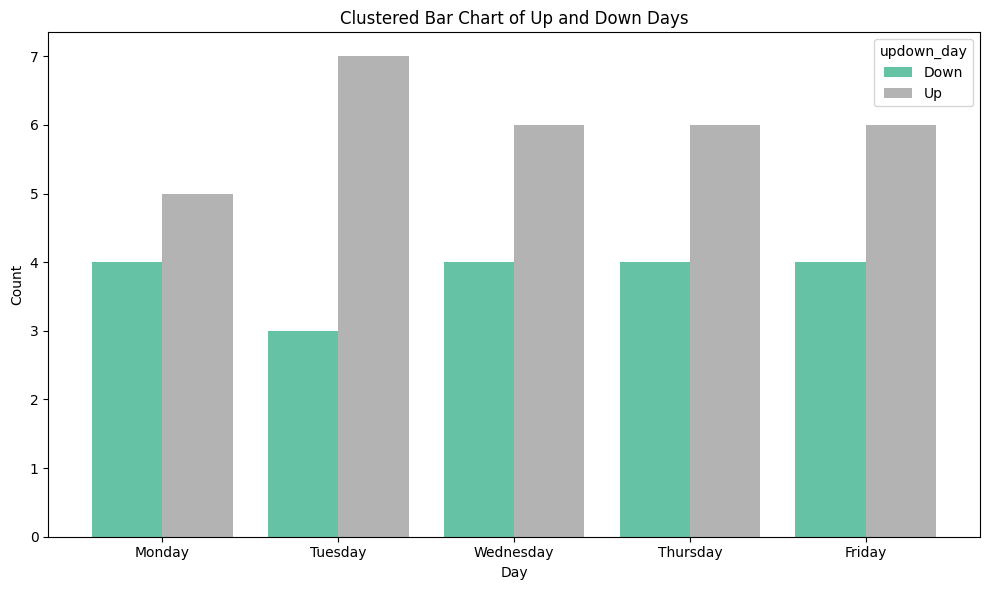

In [52]:
# Create cluster bar chart

# Drop the '% Up' column as we are interested in plotting the counts for 'Up' and 'Down'
df_pvtDay_plot = df_pvtDay.drop(columns='% Up')

# Plotting the pivot table as a clustered bar chart
df_pvtDay_plot.plot(kind='bar', figsize=(10, 6), width=0.8, colormap='Set2')

# Adding titles and labels
plt.title('Clustered Bar Chart of Up and Down Days')
plt.xlabel('Day')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Keep x-axis labels horizontal for better readability

# Show the plot
plt.tight_layout()
plt.show()

Cluster bar chart that shows up and down months for determing when to buy and sell stocks. 

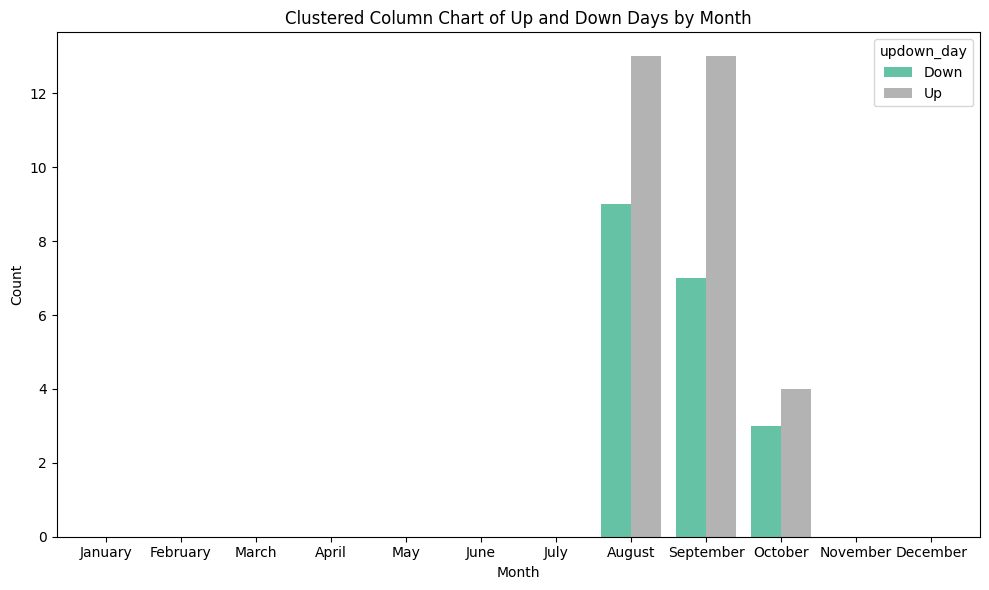

In [53]:
df_pvtMonth_plot = df_pvtMonth.drop(columns='% Up')

# Plot the pivot table as a clustered column chart (vertical bars)
df_pvtMonth_plot.plot(kind='bar', figsize=(10, 6), width=0.8, colormap='Set2')

# Adding titles and labels
plt.title('Clustered Column Chart of Up and Down Days by Month')
plt.xlabel('Month')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Keep month labels horizontal for better readability

# Show the plot
plt.tight_layout()  # Ensure the layout is nicely spaced
plt.show()

My Line Graph showing the buy, sell, and closing price

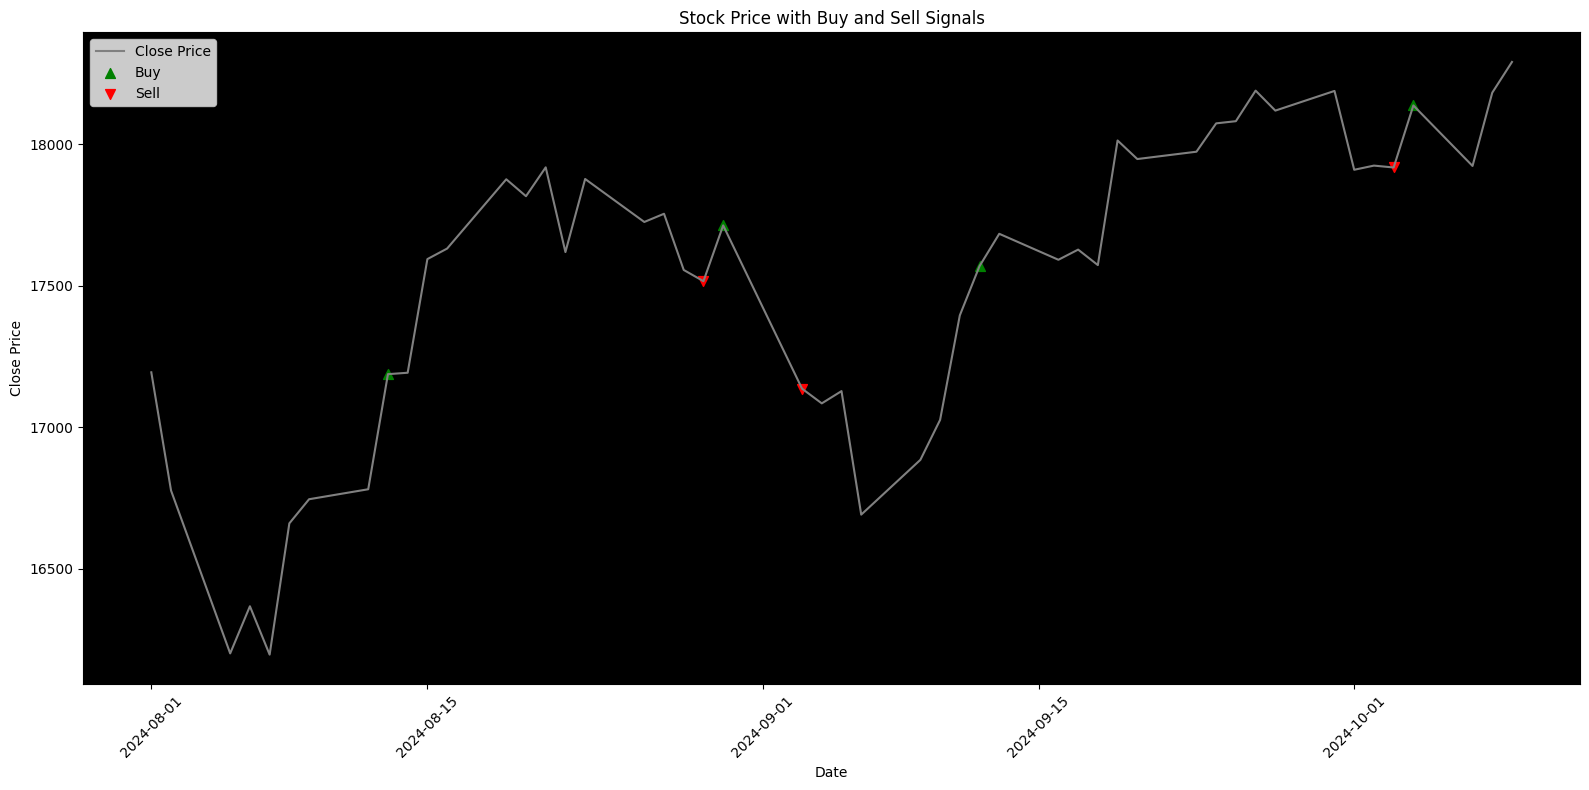

In [54]:
buy_signal = df['Signal'] == 'Buy'
sell_signal = df['Signal'] == 'Sell'

plt.figure(figsize=(16, 8))

# Plotting the line graph for 'Close' prices
plt.plot(df['Date'], df['Close'], label='Close Price', color='gray')

# Highlight buy signals in green
plt.scatter(df['Date'][buy_signal], df['Close'][buy_signal], marker='^', s=50, color='green', label='Buy')

# Highlight sell signals in red
plt.scatter(df['Date'][sell_signal], df['Close'][sell_signal], marker='v', s=50, color='red', label='Sell')

# Optional: You can highlight unchanged days in blue if you want
# unch = (df['Signal'].isna())  # Example for days with no signal (you can define this based on your logic)
# plt.scatter(df['Date'][unch], df['Close'][unch], color='blue', label='Unchanged')

# Adding labels and legend
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Stock Price with Buy and Sell Signals')
plt.legend()

plt.gca().set_facecolor('black')  # Set the background color to black

# Show the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# # Plot the line graph with arrows indicating the direction of crossover
# plt.figure(figsize=(16, 8))
# plt.plot(df_sql.index, df_sql['close'], label='Close Price', color='gray')
# plt.gca().set_facecolor('black')  # Set the background color to black
# # Highlight up days in green
# plt.scatter(df_sql['date'][buy_signal], df_sql['close'][buy_signal], color='green', label='Buy')

The reason I use the 5 day moving average because it covers the whole weekend. It allows me to day trade with stocks, when to buy and sell stocks. <br>
The reason I use the 7 day moving average because it allows you to gain insights into future predictions on stock performance. <br>
Bullish day is tuesday with the 5 day moving average with wednesday, thursday, and friday following suit <br>
Bearish day is monday within 5 day moving average. 


git checkout staging => switch between branches.<BR>
git fetch origin => update your local repository with the latest changes from the remote branch<BR>
git pull origin staging => Merge the remote staging branch into your local staging branch<BR>
git add . => add all changes in the current directory<BR>
git push origin staging